## Heuristics for routing in graphs

In [1]:
import numpy as np
import string
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def euclidean_dist(a, b, coord):
    (x1, y1) = coord[a]
    (x2, y2) = coord[b]
    return np.sqrt((x1-x2)**2+(y1-y2)**2)

def manhattan_dist(a, b, coord):
    (x1, y1) = coord[a]
    (x2, y2) = coord[b]
    return abs(x1 - x2) + abs(y1 - y2)

def non_informative(a,b):
    return 0

In [3]:
def create_maze(seed=2, drawing=True):
    np.random.seed(seed)
    letters = [l for l in string.ascii_uppercase[:25]]
    checkboard = np.array(letters[:25]).reshape((5,5))
    Graph = nx.Graph()
    for j, node in enumerate(letters):
        Graph.add_nodes_from(node)
        x, y = j // 5, j % 5
        x_min = max(0, x-1)
        x_max = min(4, x+1)+1
        y_min = max(0, y-1)
        y_max = min(4, y+1)+1
        adjacent_nodes = np.ravel(
            checkboard[x_min:x_max,y_min:y_max])
        exits = np.random.choice(adjacent_nodes, 
            size=np.random.randint(1,4), replace=False)
        for exit in exits:
            if exit not in Graph.edge[node]:
                Graph.add_edge(node, exit)
    spacing = np.arange(0.0, 1.0, 0.2)
    coordinates = [[x,y] for x in spacing \
                   for y in spacing]
    position  = {l:c for l,c in zip(letters, coordinates)}
    
    for node in Graph.edge:
        for exit in Graph.edge[node]:
            length = int(round(
                    euclidean_dist(
                        node, exit, position)*10,0))
            Graph.add_edge(node,exit,weight=length)
                
    if drawing:
        nx.draw(Graph, position, with_labels=True)
        labels = nx.get_edge_attributes(Graph,'weight')
        nx.draw_networkx_edge_labels(Graph, position, 
                                     edge_labels=labels)
        plt.show()
    
    return Graph, position 

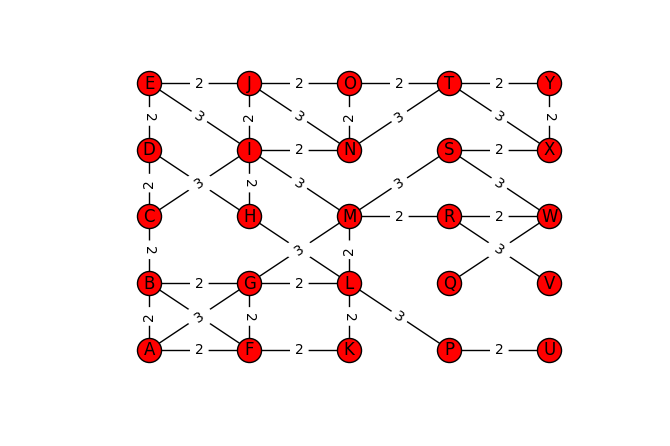

In [4]:
graph, coordinates = create_maze(seed=3)

In [5]:
def graph_weight(graph, a, b):
    return graph.edge[a][b]['weight']

def node_neighbors(graph, node):
    return graph.edge[node]

In [6]:
def reconstruct_path(connections, start, goal):
    if goal in connections:
        current = goal
        path = [current]
        while current != start:
            current = connections[current]
            path.append(current)
        return path[::-1]

def compute_path_dist(path, graph):
    if path:
        run = 0
        for step in range(len(path)-1):
            A = path[step]
            B = path[step+1]
            run += graph_weight(graph, A, B)
        return run
    else:
        return 0

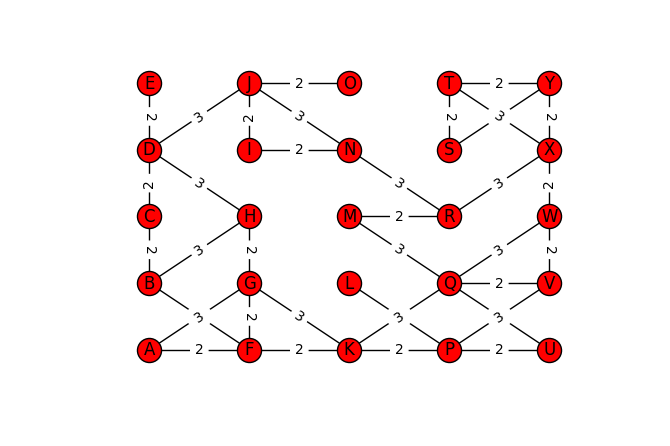

In [7]:
graph, coordinates = create_maze(seed=30)
start = 'A'
goal  = 'Y'
scoring=manhattan_dist

In [8]:
# Best-first search
path = {}
open_list = set(graph.nodes())
closed_list = {start: manhattan_dist(start, goal, 
                                     coordinates)}

while open_list:
    
    candidates = open_list&closed_list.keys()
    if len(candidates)==0:
        print ("Cannot find a way to the goal %s" % goal)
        break
    frontier = [(closed_list[node], 
                 node) for node in candidates]
    score, min_node =sorted(frontier)[0]

    if min_node==goal:
        print ("Arrived at final vertex %s" % goal)
        print ('Unvisited vertices: %i' % (len(
                    open_list)-1))
        break
    else:
        print("Processing vertex %s, " % min_node, end="")

    open_list = open_list.difference(min_node)
    neighbors = node_neighbors(graph, min_node)
    to_be_visited = list(neighbors-closed_list.keys())
    
    if len(to_be_visited) == 0:
        print ("found no exit, retracing to %s" 
               % path[min_node])
    else:
        print ("discovered %s" % str(to_be_visited))

    for node in neighbors:
        if node not in closed_list:
            closed_list[node] = scoring(node, goal, 
                                        coordinates)
            path[node] = min_node

print ('\nBest path is:', reconstruct_path(
        path, start, goal))
print ('Length of path: %i' % compute_path_dist(
        reconstruct_path(path, start, goal), graph))

Processing vertex A, discovered ['G', 'F']
Processing vertex G, discovered ['H', 'K']
Processing vertex H, discovered ['B', 'D']
Processing vertex D, discovered ['C', 'E', 'J']
Processing vertex J, discovered ['I', 'O', 'N']
Processing vertex O, found no exit, retracing to J
Processing vertex N, discovered ['R']
Processing vertex R, discovered ['X', 'M']
Processing vertex X, discovered ['W', 'Y', 'T']
Arrived at final vertex Y
Unvisited vertices: 15

Best path is: ['A', 'G', 'H', 'D', 'J', 'N', 'R', 'X', 'Y']
Length of path: 22


In [9]:
# A* 
open_list = set(graph.nodes())
closed_list = {start: manhattan_dist(
        start, goal, coordinates)}
visited = {start: 0}
path = {}

while open_list:
    
    candidates = open_list&closed_list.keys()
    if len(candidates)==0:
        print ("Cannot find a way to the goal %s" % goal)
        break
    frontier = [(closed_list[node], 
                 node) for node in candidates]
    score, min_node =sorted(frontier)[0]

    if min_node==goal:
        print ("Arrived at final vertex %s" % goal)
        print ('Unvisited vertices: %i' % (len(
                open_list)-1))
        break
    else:
        print("Processing vertex %s, " % min_node, end="")

    open_list = open_list.difference(min_node)
    current_weight = visited[min_node]
    neighbors = node_neighbors(graph, min_node)
    to_be_visited = list(neighbors-visited.keys())
        
    for node in neighbors:
        new_weight = current_weight + graph_weight(
                     graph, min_node, node)
        if node not in visited or \
        new_weight < visited[node]:
            visited[node] = new_weight
            closed_list[node] = manhattan_dist(node, goal,
                        coordinates) + new_weight
            path[node] = min_node
    
    if to_be_visited:
        print ("discovered %s" % to_be_visited)
    else:
        print ("getting back to open list")

print ('\nBest path is:', reconstruct_path(
        path, start, goal))
print ('Length of path: %i' % compute_path_dist(
        reconstruct_path(path, start, goal), graph))

Processing vertex A, discovered ['G', 'F']
Processing vertex F, discovered ['B', 'K']
Processing vertex G, discovered ['H']
Processing vertex K, discovered ['P', 'Q']
Processing vertex H, discovered ['D']
Processing vertex B, discovered ['C']
Processing vertex P, discovered ['L', 'V', 'U']
Processing vertex Q, discovered ['W', 'M']
Processing vertex C, getting back to open list
Processing vertex U, getting back to open list
Processing vertex D, discovered ['E', 'J']
Processing vertex V, getting back to open list
Processing vertex L, getting back to open list
Processing vertex W, discovered ['X']
Processing vertex E, getting back to open list
Processing vertex M, discovered ['R']
Processing vertex J, discovered ['I', 'O', 'N']
Processing vertex X, discovered ['T', 'Y']
Processing vertex R, getting back to open list
Processing vertex O, getting back to open list
Processing vertex I, getting back to open list
Arrived at final vertex Y
Unvisited vertices: 3

Best path is: ['A', 'F', 'K', '